In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
from matplotlib.cm import get_cmap
from scipy.stats import truncnorm, qmc
from tqdm import tqdm
import scipy.stats as stats
from scipy.stats import wasserstein_distance, ks_2samp
import seaborn as sns
from itertools import product
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import uniform
from matplotlib import colormaps
import matplotlib.colors as mcolors
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from torch.distributions import Distribution, Uniform, HalfNormal
from torch.distributions.utils import broadcast_all
import math
from ili.utils.distributions_pt import CustomIndependent
import itertools
import emcee

import symbolic_pofk.syren_new as syren_new
import symbolic_pofk.linear as linear
import pickle

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
sns.set(style="whitegrid", context="paper")

/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [2]:
# Load posterior ensembles for neural posterior estimators
with open('/home/x-ctirapongpra/scratch/tailed-uniform-sbi/sci-2-dim-models/uniform_power/ensemble.pkl', 'rb') as f:
    posterior_ensemble_old = pickle.load(f)
with open('/home/x-ctirapongpra/scratch/tailed-uniform-sbi/sci-2-dim-models/tailed_power/ensemble.pkl', 'rb') as f:
    posterior_ensemble = pickle.load(f)

In [3]:
# Global constants
L, N = 1000, 64
kf = 2*np.pi/L
knyq = np.pi*N/L
kedges = np.arange(0, knyq, kf)
kcenters = (kedges[:-1] + kedges[1:])/2
a = 1.0

# Original parameter ranges
param_1_range = (0.27, 0.37)   # Om
param_2_range = (0.63, 0.71)    # h
param_ranges = [param_1_range, param_2_range]

param_1_width = param_1_range[1] - param_1_range[0]
param_2_width = param_2_range[1] - param_2_range[0]

# Prior parameters
param_1_mean = (param_1_range[0] + param_1_range[1]) / 2  # Om mean
param_2_mean = (param_2_range[0] + param_2_range[1]) / 2  # h mean
param_1_std = 0.1 * (param_1_range[1] - param_1_range[0])   # Om std
param_2_std = 0.1 * (param_2_range[1] - param_2_range[0])   # h std

# simulator function
def simulator(theta):
   """Simulator: theta -> P(k)"""
   Om, h = theta
   # Also fixed (for now)
   As = 2.105  # 10^9 A_s
   Ob = 0.02242 / h ** 2
   ns = 0.9665
   w0 = -1.0  
   wa = 0.0
   mnu = 0.0
   pk_syren_theory = syren_new.pnl_new_emulated(
         kcenters, As, Om, Ob, h, ns, mnu, w0, wa, a=a
      )

   var_single = np.abs(pk_syren_theory)**2
   Nk = L**3 * kcenters**2 * kf / (2*np.pi**2)
   var_mode = var_single * 2 / Nk
   std_mode = np.sqrt(var_mode)

   pk_w_noise = pk_syren_theory + std_mode*np.random.randn(*pk_syren_theory.shape)
   return pk_w_noise

In [4]:
class TailedNormal(Distribution):
    arg_constraints = {
        'a': torch.distributions.constraints.real,
        'b': torch.distributions.constraints.dependent,
        'sigma': torch.distributions.constraints.positive,
    }
    support = torch.distributions.constraints.real
    has_rsample = False

    def __init__(self, a, b, sigma, validate_args=None):
        self.a, self.b, self.sigma = broadcast_all(a, b, sigma)
        if torch.any(self.a >= self.b):
            raise ValueError("`a` must be less than `b`.")
        
        self.Z = math.sqrt(2 * math.pi) * self.sigma + (self.b - self.a)
        self.A = math.sqrt(2 * math.pi) * self.sigma / self.Z
        self.B = (self.b - self.a) / self.Z

        self.halfnormal = HalfNormal(self.sigma)

        super().__init__(batch_shape=self.a.size(), validate_args=validate_args)

    def log_prob(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)

        logA = torch.log(self.A.to(dtype=x.dtype, device=x.device))
        logB = torch.log(self.B.to(dtype=x.dtype, device=x.device))
        log_uniform = logB - torch.log(b - a)

        # left: x <= a => z = a - x
        z_left = torch.abs(a - x)
        log_halfnorm_left = self.halfnormal.log_prob(z_left) + logA - math.log(2.0)

        # right: x >= b => z = x - b
        z_right = torch.abs(x - b)
        log_halfnorm_right = self.halfnormal.log_prob(z_right) + logA - math.log(2.0)

        return torch.where(x <= a, log_halfnorm_left,
               torch.where(x >= b, log_halfnorm_right,
               log_uniform))

    def cdf(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)
        sqrt2 = math.sqrt(2.0)

        def Phi(z):  # Standard Normal CDF
            return 0.5 * (1 + torch.erf(z / sqrt2))

        left_cdf = self.A * Phi((x - a) / sigma)
        center_cdf = 0.5 * self.A + self.B * (x - a) / (b - a)
        right_cdf = self.B + self.A * Phi((x - b) / sigma)

        return torch.where(x <= a, left_cdf,
               torch.where(x >= b, right_cdf,
               center_cdf))
    
    def icdf(self, u):
        # Helper function for the Inverse Standard Normal CDF
        def inv_Phi(p):
            # Clamping p to avoid NaNs from erfinv at the boundaries 0 and 1
            p_clamped = torch.clamp(p, 1e-9, 1.0 - 1e-9)
            return math.sqrt(2.0) * torch.erfinv(2.0 * p_clamped - 1.0)

        # Thresholds dividing the distribution regions
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        u_left_norm = u / self.A
        left_tail = self.a + self.sigma * inv_Phi(u_left_norm)

        u_right_norm = (u - self.B) / self.A
        right_tail = self.b + self.sigma * inv_Phi(u_right_norm)

        u_middle_norm = (u - thresh_left) / self.B
        middle = self.a + u_middle_norm * (self.b - self.a)

        return torch.where(u < thresh_left, left_tail,
                           torch.where(u > thresh_right, right_tail, middle))
        

    def sample(self, sample_shape=torch.Size()):
        u = torch.rand(sample_shape + self.a.shape, device=self.a.device)
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        left_tail = self.a - self.halfnormal.sample(sample_shape)
        right_tail = self.b + self.halfnormal.sample(sample_shape)

        x_middle = self.a + (u - thresh_left) * (self.b - self.a) / self.B

        return torch.where(u < thresh_left, left_tail,
               torch.where(u > thresh_right, right_tail,
               x_middle))
    
    def sample_lhs(self, n_samples):
        """Sample using Latin Hypercube Sampling"""
        # Generate LHS samples in [0,1]^d
        sampler = qmc.LatinHypercube(d=len(self.a.flatten()), seed=42)
        u_samples = sampler.random(n_samples)
        u_tensor = torch.tensor(u_samples, dtype=torch.float32, device=self.a.device)
        
        # Transform using inverse CDF
        return self.icdf(u_tensor)

    def mean(self):
        return 0.5 * (self.a + self.b)

IndependentTailedNormal = type('IndependentTailedNormal', (CustomIndependent,), {'Distribution': TailedNormal})

In [5]:
def simulator(theta):
   """Simulator: theta -> P(k)"""
   Om, h = theta
   # Also fixed (for now)
   As = 2.105  # 10^9 A_s
   Ob = 0.02242 / h ** 2
   ns = 0.9665
   w0 = -1.0  
   wa = 0.0
   mnu = 0.0
   pk_syren_theory = syren_new.pnl_new_emulated(
         kcenters, As, Om, Ob, h, ns, mnu, w0, wa, a=a
      )

   var_single = np.abs(pk_syren_theory)**2
   Nk = L**3 * kcenters**2 * kf / (2*np.pi**2)
   var_mode = var_single * 2 / Nk
   std_mode = np.sqrt(var_mode)

   pk_w_noise = pk_syren_theory + std_mode*np.random.randn(*pk_syren_theory.shape)
   return pk_w_noise

In [6]:
class SBIEvaluator:
   def __init__(self, param_names=['θ₁', 'θ₂']):
       self.param_names = param_names
   
   def c2st(self, X1, X2):
       """C2ST score - lower is better (0.5 = identical distributions)"""
       X = np.vstack([X1, X2])
       y = np.concatenate([np.zeros(len(X1)), np.ones(len(X2))])
       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
       clf = LogisticRegression(max_iter=1000)
       y_pred = clf.fit(X_train, y_train).predict(X_test)
       return hamming_loss(y_test, y_pred)
   
   def tarp_score(self, samples, true_theta):
       """TARP calibration score - lower is better"""
       alpha_levels = np.linspace(0.05, 0.95, 19)
       empirical_coverage = []
       
       for alpha in alpha_levels:
           coverage = all(
               np.percentile(samples[:, j], 100*alpha/2) <= true_theta[j] <= 
               np.percentile(samples[:, j], 100*(1-alpha/2))
               for j in range(len(true_theta))
           )
           empirical_coverage.append(coverage)
       
       expected_coverage = 1 - alpha_levels
       return np.mean(np.abs(expected_coverage - empirical_coverage))
   
   def compare(self, samples_dict, true_theta):
       """Compare multiple methods"""
       results = {}
       methods = list(samples_dict.keys())
       
       for method, samples in samples_dict.items():
           results[method] = {
               'tarp': self.tarp_score(samples, true_theta),
               'mean': np.mean(samples, axis=0),
               'std': np.std(samples, axis=0),
               'c2st_vs_others': {}
           }
       
       # C2ST comparisons
       for i, method1 in enumerate(methods):
           for method2 in methods[i+1:]:
               score = self.c2st(samples_dict[method1], samples_dict[method2])
               results[method1]['c2st_vs_others'][method2] = score
               results[method2]['c2st_vs_others'][method1] = score
       
       return results
   
   def print_results(self, results, true_theta):
       """Print concise comparison"""
       methods = list(results.keys())
       
       print("Method Comparison")
       print("-" * 50)
       
       for method in methods:
           stats = results[method]
           print(f"\n{method}:")
           print(f"  TARP: {stats['tarp']:.4f}")
           for i, param in enumerate(self.param_names):
               print(f"  {param}: Mean={stats['mean'][i]:.3f}, Std={stats['std'][i]:.3f}")
           
           if stats['c2st_vs_others']:
               c2st_str = ", ".join([f"{k}={v:.3f}" for k, v in stats['c2st_vs_others'].items()])
               print(f"  C2ST: {c2st_str}")

In [7]:
# Load test points from grid dataset
mcmc_folder = '/home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/grid'
test_points_all = np.load(f'{mcmc_folder}/test_points.npy')
mcmc_samples_all = np.load(f'{mcmc_folder}/mcmc_samples.npy')
observations_all = np.load(f'{mcmc_folder}/observations.npy')


# Randomly select 3 test points
n_test_points = 3
random_indices = np.random.choice(len(test_points_all), n_test_points, replace=False)

# Extract corresponding MCMC samples using indices
mcmc_samples_list = []
test_points_selected = []

for idx in random_indices:
    mcmc_samples = mcmc_samples_all[idx]  # Shape: (n_samples, 2)
    mcmc_samples_list.append(mcmc_samples)
    test_points_selected.append(test_points_all[idx])
    print(f"\nLoaded MCMC samples for index {idx}: shape {mcmc_samples.shape}")
    print(f"  Mean: {np.mean(mcmc_samples, axis=0)}")
    print(f"  Std:  {np.std(mcmc_samples, axis=0)}")

test_points_selected = np.array(test_points_selected)


Loaded MCMC samples for index 66: shape (8000, 2)
  Mean: [0.28867258 0.6529688 ]
  Std:  [0.0040404  0.00372213]

Loaded MCMC samples for index 304: shape (8000, 2)
  Mean: [0.33367396 0.65694986]
  Std:  [0.00491058 0.00379401]

Loaded MCMC samples for index 141: shape (8000, 2)
  Mean: [0.30828872 0.63280963]
  Std:  [0.00437431 0.00372974]


In [8]:
# Generate observations for each test point
observations_list = []

for i, theta_true in enumerate(test_points_selected):
    print(f"\nTest point {i+1}/{n_test_points}: {theta_true}")
    
    # Generate observation
    x_obs = simulator(theta_true)
    
    # Apply log10 transform (matching training data)
    x_obs_log = np.log10(x_obs)
    
    # Handle NaN values
    mask = np.isnan(x_obs_log)
    if np.any(mask):
        assert np.any(~mask), f"NaN for test point {i} (theta={theta_true})"
        x_obs_log[mask] = np.nanmean(x_obs_log)
    
    observations_list.append(x_obs_log)
    print(f"  Observation shape: {x_obs_log.shape}")


Test point 1/3: [0.28578947 0.65526316]
  Observation shape: (31,)

Test point 2/3: [0.34894737 0.64684211]
  Observation shape: (31,)

Test point 3/3: [0.30684211 0.63421053]
  Observation shape: (31,)


/tmp/ipykernel_3303641/3660026810.py:11: RuntimeWarning: invalid value encountered in log10
  x_obs_log = np.log10(x_obs)


In [9]:
# Sample from both neural ensembles
n_posterior_samples = 8000

uniform_npe_samples_list = []
tailed_npe_samples_list = []

print(f"Sampling {n_posterior_samples} posterior samples from both ensembles:")

for i, x_obs in enumerate(observations_list):
    # Sample from Uniform NPE
    print("  Sampling from Uniform NPE...")
    samples_uniform = posterior_ensemble_old.sample((n_posterior_samples,), x_obs).cpu().numpy()
    uniform_npe_samples_list.append(samples_uniform)
    
    # Sample from TailedNormal NPE
    print("  Sampling from TailedNormal NPE...")
    samples_tailed = posterior_ensemble.sample((n_posterior_samples,), x_obs).cpu().numpy()
    tailed_npe_samples_list.append(samples_tailed)

INFO:root:Sampling models with [857, 843, 832, 806, 797, 796, 790, 782, 754, 748] samples each.


Sampling 8000 posterior samples from both ensembles:
  Sampling from Uniform NPE...


Drawing 857 posterior samples:   0%|          | 0/857 [00:00<?, ?it/s]

Drawing 748 posterior samples: 100%|██████████| 748/748 [00:00<00:00, 78813.76it/s]
INFO:root:Sampling models with [1253, 1011, 779, 733, 733, 731, 719, 695, 686, 665] samples each.


  Sampling from TailedNormal NPE...


Drawing 1253 posterior samples: 2000it [00:00, 5810.97it/s]                          
Drawing 1011 posterior samples: 2000it [00:00, 4506.99it/s]             
Drawing 665 posterior samples: 100%|██████████| 665/665 [00:00<00:00, 48150.47it/s]
INFO:root:Sampling models with [857, 843, 832, 806, 797, 796, 790, 782, 754, 748] samples each.


  Sampling from Uniform NPE...


Drawing 748 posterior samples: 100%|██████████| 748/748 [00:00<00:00, 9210.86it/s]
INFO:root:Sampling models with [1253, 1011, 779, 733, 733, 731, 719, 695, 686, 665] samples each.


  Sampling from TailedNormal NPE...


Drawing 1253 posterior samples: 2000it [00:00, 83756.26it/s]            
Drawing 1011 posterior samples: 2000it [00:00, 59153.44it/s]            
Drawing 665 posterior samples: 100%|██████████| 665/665 [00:00<00:00, 51366.71it/s]
INFO:root:Sampling models with [857, 843, 832, 806, 797, 796, 790, 782, 754, 748] samples each.


  Sampling from Uniform NPE...


Drawing 748 posterior samples: 100%|██████████| 748/748 [00:00<00:00, 86815.52it/s]
INFO:root:Sampling models with [1253, 1011, 779, 733, 733, 731, 719, 695, 686, 665] samples each.


  Sampling from TailedNormal NPE...


Drawing 1253 posterior samples: 2000it [00:00, 75421.52it/s]            
Drawing 1011 posterior samples: 2000it [00:00, 56976.21it/s]            
Drawing 665 posterior samples: 100%|██████████| 665/665 [00:00<00:00, 44276.72it/s]


In [10]:
# Evaluate all test points using the SBIEvaluator
evaluator = SBIEvaluator(param_names=['Om', 'h'])

all_results = []

for i in range(n_test_points):
    print(f"\n{'='*70}")
    print(f"TEST POINT {i+1}/{n_test_points}")
    print(f"{'='*70}")
    print(f"True parameters: {test_points_selected[i]}")
    print(f"Index: {random_indices[i]}")
    
    # Prepare samples dictionary
    samples_dict = {
        'MCMC_Reference': mcmc_samples_list[i],
        'Uniform_NPE': uniform_npe_samples_list[i],
        'TailedNormal_NPE': tailed_npe_samples_list[i]
    }
    
    # Evaluate
    results = evaluator.compare(samples_dict, test_points_selected[i])
    all_results.append(results)
    
    # Print results
    evaluator.print_results(results, test_points_selected[i])


TEST POINT 1/3
True parameters: [0.28578947 0.65526316]
Index: 66
Method Comparison
--------------------------------------------------

MCMC_Reference:
  TARP: 0.2632
  Om: Mean=0.289, Std=0.004
  h: Mean=0.653, Std=0.004
  C2ST: Uniform_NPE=0.380, TailedNormal_NPE=0.426

Uniform_NPE:
  TARP: 0.3158
  Om: Mean=0.292, Std=0.006
  h: Mean=0.650, Std=0.007
  C2ST: MCMC_Reference=0.380, TailedNormal_NPE=0.471

TailedNormal_NPE:
  TARP: 0.2789
  Om: Mean=0.291, Std=0.007
  h: Mean=0.651, Std=0.007
  C2ST: MCMC_Reference=0.426, Uniform_NPE=0.471

TEST POINT 2/3
True parameters: [0.34894737 0.64684211]
Index: 304
Method Comparison
--------------------------------------------------

MCMC_Reference:
  TARP: 0.5000
  Om: Mean=0.334, Std=0.005
  h: Mean=0.657, Std=0.004
  C2ST: Uniform_NPE=0.180, TailedNormal_NPE=0.221

Uniform_NPE:
  TARP: 0.2684
  Om: Mean=0.345, Std=0.008
  h: Mean=0.649, Std=0.006
  C2ST: MCMC_Reference=0.180, TailedNormal_NPE=0.479

TailedNormal_NPE:
  TARP: 0.2632
  Om: Me

Saved histogram plot: sci-2-dim-figures/mcmc_evaluation_histograms.png


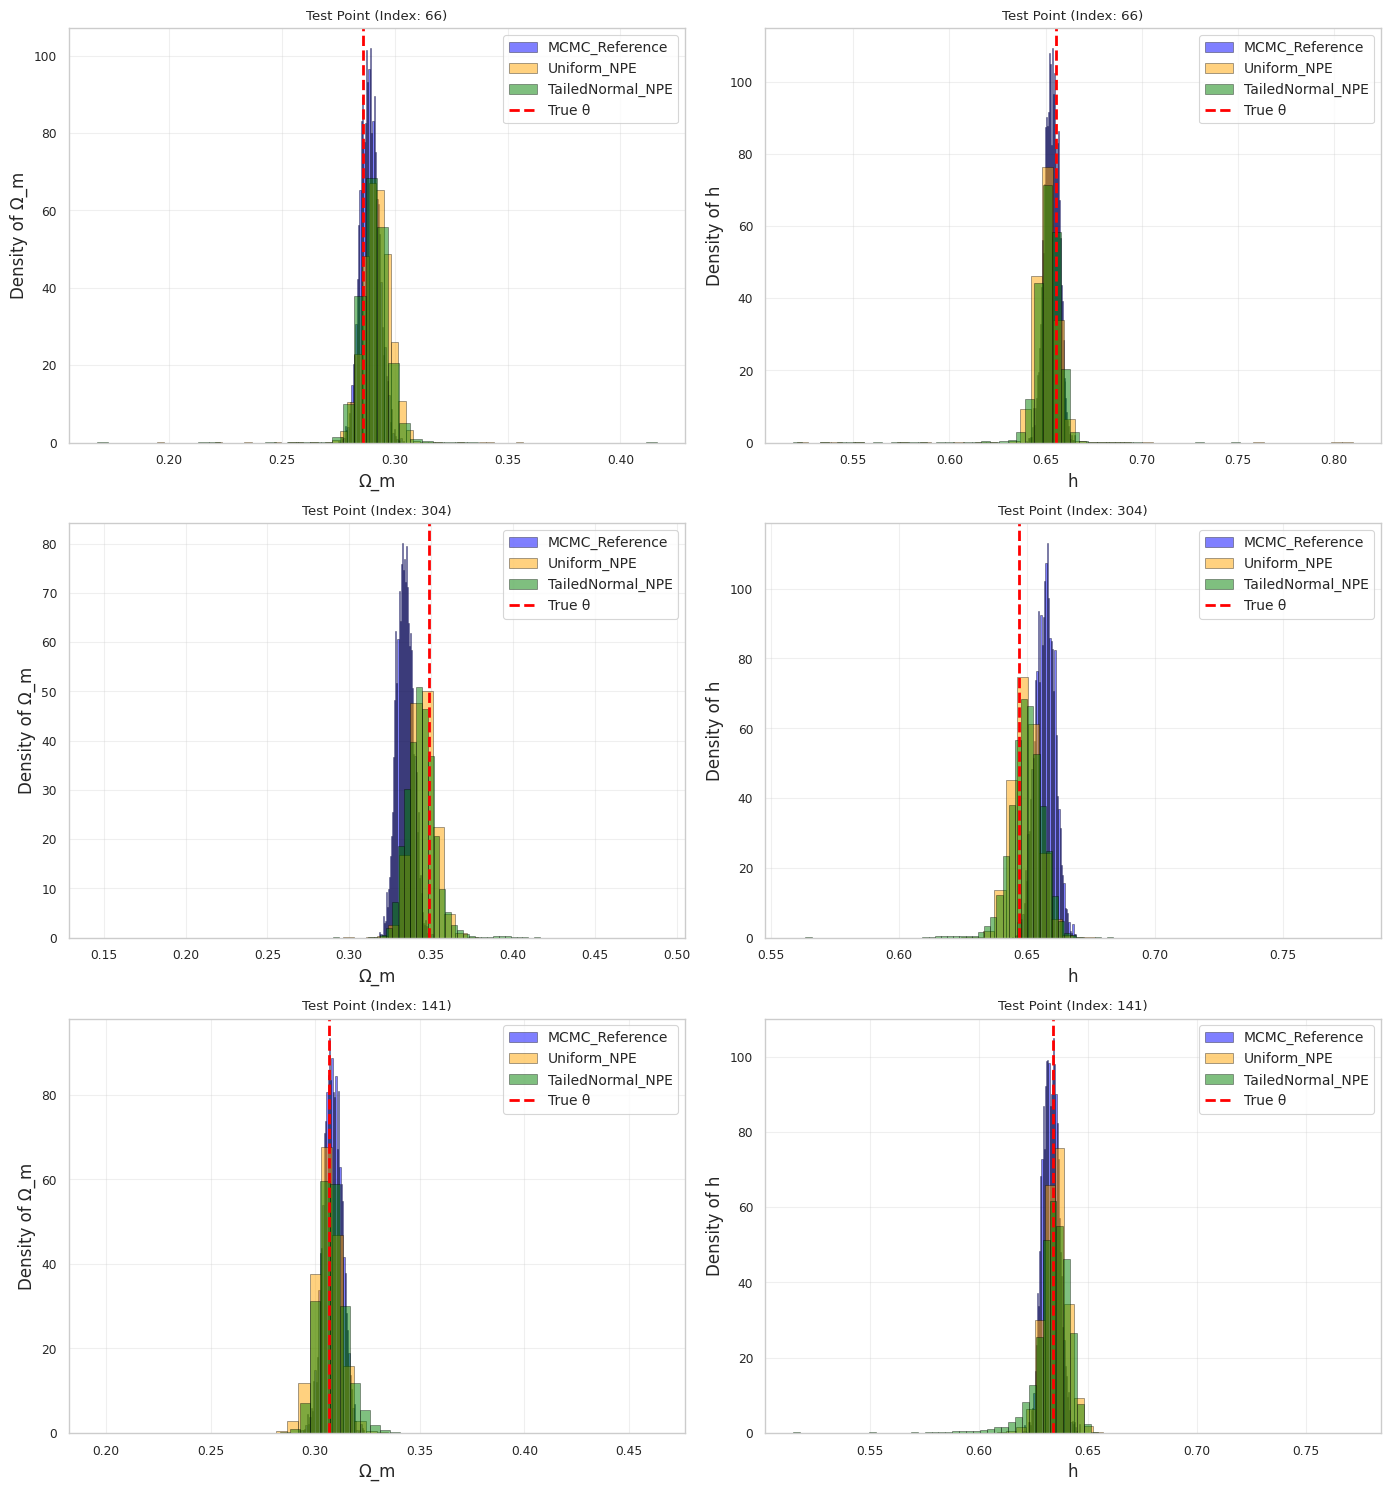

In [11]:
# Create visualization plots for all test points
fig, axes = plt.subplots(n_test_points, 2, figsize=(14, 5*n_test_points))

if n_test_points == 1:
    axes = axes.reshape(1, -1)

methods = ['MCMC_Reference', 'Uniform_NPE', 'TailedNormal_NPE']
colors = ['blue', 'orange', 'green']
param_names = ['Ω_m', 'h']

for test_idx in range(n_test_points):
    samples_list = [
        mcmc_samples_list[test_idx],
        uniform_npe_samples_list[test_idx],
        tailed_npe_samples_list[test_idx]
    ]
    
    for param_idx in range(2):
        ax = axes[test_idx, param_idx]
        
        # Plot histograms
        for method, samples, color in zip(methods, samples_list, colors):
            ax.hist(samples[:, param_idx], bins=50, alpha=0.5, density=True, 
                   label=method, color=color, edgecolor='black', linewidth=0.5)
        
        # Plot true value
        true_val = test_points_selected[test_idx, param_idx]
        ax.axvline(true_val, color='red', linestyle='--', linewidth=2, label='True θ')
        
        # Labels and title
        ax.set_xlabel(param_names[param_idx], fontsize=12)
        ax.set_ylabel(f'Density of {param_names[param_idx]}', fontsize=12)
        ax.set_title(f'Test Point (Index: {random_indices[test_idx]})')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('sci-2-dim-figures', exist_ok=True)
filename = 'sci-2-dim-figures/mcmc_evaluation_histograms.png'
plt.savefig(filename, bbox_inches='tight', dpi=150)
print(f"Saved histogram plot: {filename}")
plt.show()

Evaluate all test points from the rectangular grid against both neural ensemble models and MCMC ground truth.

In [29]:
class RectGridEvaluator:
    """Evaluator for rectangular grid of test points"""

    def __init__(self, param_ranges):
        self.param_ranges = param_ranges

    def c2st(self, X1, X2):
        """C2ST score - measures distributional similarity"""
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import hamming_loss

        X = np.vstack([X1, X2])
        y = np.concatenate([np.zeros(len(X1)), np.ones(len(X2))])
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )
        clf = LogisticRegression(max_iter=1000)
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        return hamming_loss(y_test, y_pred)

    def load_grid_data(self, mcmc_folder, n_points_per_dim=20):
        """
        Load MCMC grid data from disk

        Returns:
            test_points: (n_points, 2) array of test points
            mcmc_samples: (n_points, n_samples, 2) array of MCMC samples
            observations: (n_points, n_k_bins) array of observations
        """
        import glob

        # Try to load data
        try:
            test_points = np.load(f'{mcmc_folder}/test_points.npy')
            mcmc_samples = np.load(f'{mcmc_folder}/mcmc_samples.npy')
            observations = np.load(f'{mcmc_folder}/observations.npy')
            print(f"Loaded grid data:")
            return test_points, mcmc_samples, observations
        except:
            pass

        raise FileNotFoundError(f"No grid data found in {mcmc_folder}")

    def evaluate_npe_on_grid(self, posterior_dict, observations, n_samples=8000):
        """
        Sample from NPE posteriors for all grid observations

        Args:
            posterior_dict: Dictionary of {name: posterior_ensemble}
            observations: Array of observations (n_points, n_features)
            n_samples: Number of posterior samples per point

        Returns:
            results_dict: {method_name: samples_array} where samples_array
                         has shape (n_points, n_samples, 2)
        """
        results = {}

        for name, posterior in posterior_dict.items():
            print(f"\nSampling from {name}...")
            samples_list = []

            for i, x_obs in enumerate(tqdm(observations, desc=f"  {name}")):
                # Convert to log10 if needed
                if not np.all(x_obs < 10):  # Assume already log10 if all values < 10
                    x_obs_log = np.log10(x_obs)
                    mask = np.isnan(x_obs_log)
                    if np.any(mask):
                        x_obs_log[mask] = np.nanmean(x_obs_log)
                    x_obs = x_obs_log

                # Sample from posterior
                samples = posterior.sample((n_samples,), x_obs).cpu().numpy()
                samples_list.append(samples)

            results[name] = np.array(samples_list)
            print(f"  Shape: {results[name].shape}")

        return results

    def save_npe_samples(self, npe_results, save_folder):
        """
        Save NPE samples to disk

        Args:
            npe_results: Dictionary of NPE samples {name: (n_points, n_samples, 2)}
            save_folder: Path to save the samples
        """
        print("\nSaving NPE samples to disk...")
        for method_name, samples in npe_results.items():
            filename = f'{save_folder}/{method_name.lower()}_samples.npy'
            np.save(filename, samples)
            file_size_mb = samples.nbytes / 1e6
            print(f"  Saved {filename}")
            print(f"    Shape: {samples.shape}, Size: {file_size_mb:.2f} MB")

        print("\nAll NPE samples saved successfully!")

    def compute_radial_distance(self, test_points, normalize=True):
        """
        Compute radial distance of test points from parameter space center

        Args:
            test_points: (n_points, 2) array of test points
            normalize: If True, normalize by parameter ranges before computing distance

        Returns:
            distances: (n_points,) array of distances from center
            center: (2,) array of parameter space center
        """
        # Compute center of parameter space
        center = np.array([
            (self.param_ranges[0][0] + self.param_ranges[0][1]) / 2,
            (self.param_ranges[1][0] + self.param_ranges[1][1]) / 2
        ])

        if normalize:
            # Normalize by parameter ranges to give equal weight to both dimensions
            param_widths = np.array([
                self.param_ranges[0][1] - self.param_ranges[0][0],
                self.param_ranges[1][1] - self.param_ranges[1][0]
            ])
            normalized_points = (test_points - center) / param_widths
            distances = np.linalg.norm(normalized_points, axis=1)
        else:
            distances = np.linalg.norm(test_points - center, axis=1)

        return distances, center

    def group_by_radius(self, test_points, distances, n_bins=5):
        """
        Group test points into radial bins

        Args:
            test_points: (n_points, 2) array of test points
            distances: (n_points,) array of distances from center
            n_bins: Number of radial bins

        Returns:
            radial_groups: List of dictionaries with bin info
        """
        # Create bins
        min_dist = np.min(distances)
        max_dist = np.max(distances)
        bin_edges = np.linspace(min_dist, max_dist, n_bins + 1)

        radial_groups = []
        for i in range(n_bins):
            mask = (distances >= bin_edges[i]) & (distances < bin_edges[i+1])
            if i == n_bins - 1:  # Include right edge in last bin
                mask = (distances >= bin_edges[i]) & (distances <= bin_edges[i+1])

            indices = np.where(mask)[0]
            radial_groups.append({
                'bin_idx': i,
                'bin_edges': (bin_edges[i], bin_edges[i+1]),
                'bin_center': (bin_edges[i] + bin_edges[i+1]) / 2,
                'indices': indices,
                'n_points': len(indices),
                'mean_distance': np.mean(distances[indices]) if len(indices) > 0 else 0
            })

        return radial_groups, bin_edges

    def compute_c2st_radial(self, mcmc_samples, npe_results, test_points, n_bins=5):
        """
        Compute C2ST scores as a function of radial distance from center

        Args:
            mcmc_samples: (n_points, n_mcmc_samples, 2) MCMC samples
            npe_results: Dictionary of NPE samples {name: (n_points, n_samples, 2)}
            test_points: (n_points, 2) array of test points
            n_bins: Number of radial bins

        Returns:
            c2st_radial: Dictionary of results for each comparison
        """
        # Compute distances
        distances, center = self.compute_radial_distance(test_points)
        radial_groups, bin_edges = self.group_by_radius(test_points, distances, n_bins)

        print(f"\nRadial binning:")
        print(f"  Center: Om={center[0]:.3f}, h={center[1]:.3f}")
        print(f"  Number of bins: {n_bins}")
        print(f"\nPoints per bin:")
        for group in radial_groups:
            print(f"  Bin {group['bin_idx']}: r=[{group['bin_edges'][0]:.3f}, {group['bin_edges'][1]:.3f}], "
                  f"n={group['n_points']}, mean_r={group['mean_distance']:.3f}")

        methods = list(npe_results.keys())
        c2st_radial = {
            'bin_edges': bin_edges,
            'radial_groups': radial_groups,
            'center': center,
            'comparisons': {}
        }

        # MCMC vs each NPE
        for method in methods:
            comparison_name = f"MCMC_vs_{method}"
            c2st_by_bin = []

            print(f"\nComputing radial C2ST for {comparison_name}...")
            for group in radial_groups:
                if group['n_points'] == 0:
                    c2st_by_bin.append(np.nan)
                    continue

                # Compute average C2ST for all points in this bin
                c2st_values = []
                for idx in group['indices']:
                    c2st_val = self.c2st(mcmc_samples[idx], npe_results[method][idx])
                    c2st_values.append(c2st_val)

                c2st_by_bin.append(np.mean(c2st_values))
                print(f"  Bin {group['bin_idx']}: C2ST={np.mean(c2st_values):.3f} "
                      f"(std={np.std(c2st_values):.3f}, n={len(c2st_values)})")

            c2st_radial['comparisons'][comparison_name] = {
                'c2st_by_bin': np.array(c2st_by_bin),
                'bin_centers': [g['bin_center'] for g in radial_groups]
            }

        # NPE vs NPE comparisons
        for i, m1 in enumerate(methods):
            for m2 in methods[i+1:]:
                comparison_name = f"{m1}_vs_{m2}"
                c2st_by_bin = []

                print(f"\nComputing radial C2ST for {comparison_name}...")
                for group in radial_groups:
                    if group['n_points'] == 0:
                        c2st_by_bin.append(np.nan)
                        continue

                    c2st_values = []
                    for idx in group['indices']:
                        c2st_val = self.c2st(npe_results[m1][idx], npe_results[m2][idx])
                        c2st_values.append(c2st_val)

                    c2st_by_bin.append(np.mean(c2st_values))
                    print(f"  Bin {group['bin_idx']}: C2ST={np.mean(c2st_values):.3f} "
                          f"(std={np.std(c2st_values):.3f}, n={len(c2st_values)})")

                c2st_radial['comparisons'][comparison_name] = {
                    'c2st_by_bin': np.array(c2st_by_bin),
                    'bin_centers': [g['bin_center'] for g in radial_groups]
                }

        return c2st_radial

    def plot_c2st_radial(self, c2st_radial, save_path=None):
        """
        Plot C2ST scores as a function of radial distance

        Args:
            c2st_radial: Results from compute_c2st_radial
            save_path: Optional path to save figure
        """
        comparisons = list(c2st_radial['comparisons'].keys())

        plt.figure(figsize=(10, 6))

        for comp in comparisons:
            data = c2st_radial['comparisons'][comp]
            bin_centers = data['bin_centers']
            c2st_values = data['c2st_by_bin']
            
            # Format label for legend
            label = comp.replace('_', ' ')
            plt.plot(bin_centers, c2st_values, 'o-', linewidth=2, markersize=8, label=label)

        plt.axhline(0.5, color='gray', linestyle='--', linewidth=2, label='Ideal C2ST=0.5')
        plt.xlabel('Normalized Radial Distance from Center', fontsize=12)
        plt.ylabel('Average Error Metric [C2ST]', fontsize=12)
        plt.title('C2ST Score vs Radial Distance', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=10)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            print(f"\nSaved radial plot to: {save_path}")

        plt.show()

    def compute_c2st_grid(self, mcmc_samples, npe_results, n_points_per_dim):
        """
        Compute C2ST scores across the grid

        Args:
            mcmc_samples: (n_points, n_mcmc_samples, 2) MCMC samples
            npe_results: Dictionary of NPE samples {name: (n_points, n_samples, 2)}
            n_points_per_dim: Grid dimension

        Returns:
            c2st_grid: Dictionary of C2ST heatmaps
        """
        methods = list(npe_results.keys())
        c2st_grid = {}

        # MCMC vs each NPE
        for method in methods:
            comparison_name = f"MCMC_vs_{method}"
            c2st_values = []

            print(f"\nComputing C2ST for {comparison_name}...")
            for idx in tqdm(range(len(mcmc_samples))):
                c2st_val = self.c2st(mcmc_samples[idx], npe_results[method][idx])
                c2st_values.append(c2st_val)

            c2st_values = np.array(c2st_values)
            c2st_grid[comparison_name] = c2st_values.reshape(n_points_per_dim,
                                                             n_points_per_dim)

        # NPE vs NPE comparisons
        for i, m1 in enumerate(methods):
            for m2 in methods[i+1:]:
                comparison_name = f"{m1}_vs_{m2}"
                c2st_values = []

                print(f"\nComputing C2ST for {comparison_name}...")
                for idx in tqdm(range(len(mcmc_samples))):
                    c2st_val = self.c2st(npe_results[m1][idx], npe_results[m2][idx])
                    c2st_values.append(c2st_val)

                c2st_values = np.array(c2st_values)
                c2st_grid[comparison_name] = c2st_values.reshape(n_points_per_dim,
                                                                 n_points_per_dim)

        return c2st_grid

    def plot_c2st_heatmaps(self, c2st_grid, n_points_per_dim, save_path=None):
        """
        Plot C2ST scores as heatmaps

        Args:
            c2st_grid: Dictionary of C2ST arrays
            n_points_per_dim: Grid dimension
            save_path: Optional path to save figure
        """
        comparisons = list(c2st_grid.keys())
        n_comparisons = len(comparisons)

        fig, axes = plt.subplots(n_comparisons, 1,
                                figsize=(12, 8*n_comparisons))
        if n_comparisons == 1:
            axes = [axes]

        for i, comp in enumerate(comparisons):
            im = axes[i].imshow(c2st_grid[comp], cmap='RdYlBu_r',
                               vmin=0.3, vmax=0.7,
                               extent=[self.param_ranges[0][0],
                                      self.param_ranges[0][1],
                                      self.param_ranges[1][0],
                                      self.param_ranges[1][1]],
                               origin='lower', aspect='auto')

            # Add text annotations
            for j in range(n_points_per_dim):
                for k in range(n_points_per_dim):
                    value = c2st_grid[comp][j, k]
                    color = 'white' if value > 0.5 else 'black'

                    # Calculate pixel coordinates
                    x_extent = self.param_ranges[0][1] - self.param_ranges[0][0]
                    y_extent = self.param_ranges[1][1] - self.param_ranges[1][0]
                    x_pos = self.param_ranges[0][0] + (k + 0.5) * x_extent / n_points_per_dim
                    y_pos = self.param_ranges[1][0] + (j + 0.5) * y_extent / n_points_per_dim

                    axes[i].text(x_pos, y_pos, f'{value:.2f}',
                               ha='center', va='center',
                               color=color, fontsize=6)

            axes[i].set_title(comp.replace('_', ' '), fontsize=16)
            axes[i].set_xlabel('Ω_m', fontsize=14)
            axes[i].set_ylabel('h', fontsize=14)

            cbar = fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
            cbar.set_label('C2ST Score', fontsize=12)
            cbar.ax.axhline(0.5, color='black', linestyle='--', linewidth=2)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            print(f"\nSaved heatmap to: {save_path}")

        plt.show()


# Initialize evaluator
rect_evaluator = RectGridEvaluator(param_ranges)

# Evaluate NPE models on grid
posterior_dict_grid = {
    'Uniform_NPE': posterior_ensemble_old,
    'TailedNormal_NPE': posterior_ensemble
}

In [13]:
# Load grid MCMC data
mcmc_folder_grid = '/home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/grid'
n_points_per_dim = 20

test_points_grid, mcmc_samples_grid, observations_grid = rect_evaluator.load_grid_data(
    mcmc_folder_grid, n_points_per_dim=n_points_per_dim
)

print(f"\nGrid: {n_points_per_dim} × {n_points_per_dim} = {len(test_points_grid)} test points")
print(f"\nFirst 5 test points:")
for i in range(min(5, len(test_points_grid))):
    print(f"  {i}: {test_points_grid[i]}")



Loaded grid data:

Grid: 20 × 20 = 400 test points

First 5 test points:
  0: [0.27 0.63]
  1: [0.27       0.63421053]
  2: [0.27       0.63842105]
  3: [0.27       0.64263158]
  4: [0.27       0.64684211]


In [14]:
# Evaluate NPE models on grid
posterior_dict_grid = {
    'Uniform_NPE': posterior_ensemble_old,
    'TailedNormal_NPE': posterior_ensemble
}

n_posterior_samples_grid = 8000

npe_results_grid = rect_evaluator.evaluate_npe_on_grid(
    posterior_dict_grid,
    observations_grid,
    n_samples=n_posterior_samples_grid
)

print(f"\nNPE evaluation complete!")
print(f"Results:")
for method, samples in npe_results_grid.items():
    print(f"  {method}: {samples.shape}")



Sampling from Uniform_NPE...


  Uniform_NPE:   4%|▍         | 16/400 [00:05<01:10,  5.48it/s]/tmp/ipykernel_3303641/3367764486.py:67: RuntimeWarning: invalid value encountered in log10
  x_obs_log = np.log10(x_obs)
INFO:root:Sampling models with [857, 843, 832, 806, 797, 796, 790, 782, 754, 748] samples each.
  Uniform_NPE: 100%|██████████| 400/400 [02:19<00:00,  2.88it/s]


  Shape: (400, 8000, 2)

Sampling from TailedNormal_NPE...


  TailedNormal_NPE:   0%|          | 0/400 [00:00<?, ?it/s]INFO:root:Sampling models with [1253, 1011, 779, 733, 733, 731, 719, 695, 686, 665] samples each.
Drawing 1253 posterior samples: 2000it [00:00, 75035.63it/s]            
Drawing 1011 posterior samples: 2000it [00:01, 1872.01it/s]                         
  TailedNormal_NPE:   0%|          | 1/400 [00:01<11:27,  1.72s/it]INFO:root:Sampling models with [1253, 1011, 779, 733, 733, 731, 719, 695, 686, 665] samples each.
Drawing 1253 posterior samples: 2000it [00:00, 86458.21it/s]            
Drawing 1011 posterior samples: 2000it [00:00, 63634.91it/s]            
  TailedNormal_NPE:   0%|          | 2/400 [00:01<05:23,  1.23it/s]INFO:root:Sampling models with [1253, 1011, 779, 733, 733, 731, 719, 695, 686, 665] samples each.
Drawing 1253 posterior samples: 2000it [00:00, 84748.82it/s]            
Drawing 1011 posterior samples: 2000it [00:00, 61981.73it/s]            
  TailedNormal_NPE:   1%|          | 3/400 [00:02<03:28,  1.91i

  Shape: (400, 8000, 2)

NPE evaluation complete!
Results:
  Uniform_NPE: (400, 8000, 2)
  TailedNormal_NPE: (400, 8000, 2)


In [15]:
# Save NPE grid samples to disk
rect_evaluator.save_npe_samples(npe_results_grid, mcmc_folder_grid)


Saving NPE samples to disk...
  Saved /home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/grid/uniform_npe_samples.npy
    Shape: (400, 8000, 2), Size: 25.60 MB
  Saved /home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/grid/tailednormal_npe_samples.npy
    Shape: (400, 8000, 2), Size: 25.60 MB

All NPE samples saved successfully!


In [16]:
# Compute C2ST scores across the grid
c2st_grid_rect = rect_evaluator.compute_c2st_grid(
    mcmc_samples_grid,
    npe_results_grid,
    n_points_per_dim
)

print(f"\nC2ST grid computation complete!")
print(f"Comparisons computed:")
for comp_name, grid in c2st_grid_rect.items():
    print(f"  {comp_name}: shape {grid.shape}, mean={np.mean(grid):.3f}, std={np.std(grid):.3f}")



Computing C2ST for MCMC_vs_Uniform_NPE...


100%|██████████| 400/400 [00:04<00:00, 80.58it/s]



Computing C2ST for MCMC_vs_TailedNormal_NPE...


100%|██████████| 400/400 [00:04<00:00, 87.80it/s]



Computing C2ST for Uniform_NPE_vs_TailedNormal_NPE...


100%|██████████| 400/400 [00:04<00:00, 99.45it/s] 


C2ST grid computation complete!
Comparisons computed:
  MCMC_vs_Uniform_NPE: shape (20, 20), mean=0.348, std=0.099
  MCMC_vs_TailedNormal_NPE: shape (20, 20), mean=0.373, std=0.097
  Uniform_NPE_vs_TailedNormal_NPE: shape (20, 20), mean=0.446, std=0.048


In [30]:
# Compute radial C2ST scores
n_radial_bins = 10

c2st_radial_results = rect_evaluator.compute_c2st_radial(
    mcmc_samples_grid,
    npe_results_grid,
    test_points_grid,
    n_bins=n_radial_bins
)

print(f"\nRadial C2ST computation complete!")


Radial binning:
  Center: Om=0.320, h=0.670
  Number of bins: 10

Points per bin:
  Bin 0: r=[0.037, 0.104], n=12, mean_r=0.068
  Bin 1: r=[0.104, 0.171], n=20, mean_r=0.137
  Bin 2: r=[0.171, 0.238], n=28, mean_r=0.202
  Bin 3: r=[0.238, 0.305], n=52, mean_r=0.274
  Bin 4: r=[0.305, 0.372], n=44, mean_r=0.344
  Bin 5: r=[0.372, 0.439], n=60, mean_r=0.404
  Bin 6: r=[0.439, 0.506], n=68, mean_r=0.470
  Bin 7: r=[0.506, 0.573], n=68, mean_r=0.531
  Bin 8: r=[0.573, 0.640], n=36, mean_r=0.607
  Bin 9: r=[0.640, 0.707], n=12, mean_r=0.683

Computing radial C2ST for MCMC_vs_Uniform_NPE...
  Bin 0: C2ST=0.422 (std=0.040, n=12)
  Bin 1: C2ST=0.403 (std=0.090, n=20)
  Bin 2: C2ST=0.388 (std=0.088, n=28)
  Bin 3: C2ST=0.343 (std=0.088, n=52)
  Bin 4: C2ST=0.328 (std=0.089, n=44)
  Bin 5: C2ST=0.331 (std=0.101, n=60)
  Bin 6: C2ST=0.328 (std=0.095, n=68)
  Bin 7: C2ST=0.345 (std=0.108, n=68)
  Bin 8: C2ST=0.361 (std=0.108, n=36)
  Bin 9: C2ST=0.371 (std=0.087, n=12)

Computing radial C2ST for 


Saved radial plot to: sci-2-dim-figures/grid_c2st_radial.png


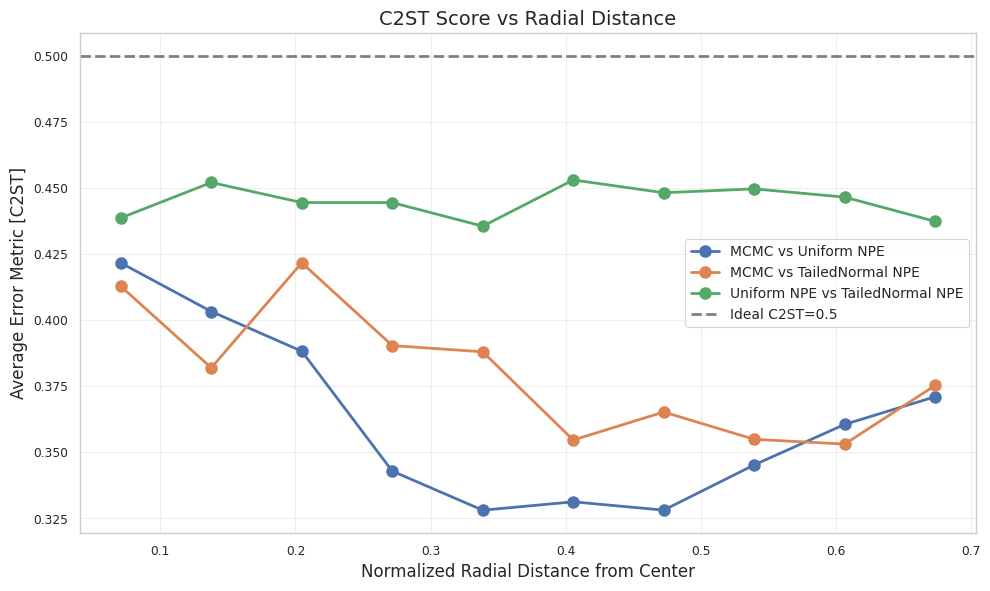

In [31]:
# Plot radial C2ST results
save_path = 'sci-2-dim-figures/grid_c2st_radial.png'

rect_evaluator.plot_c2st_radial(c2st_radial_results, save_path=save_path)


Saved heatmap to: sci-2-dim-figures/grid_c2st_heatmaps.png


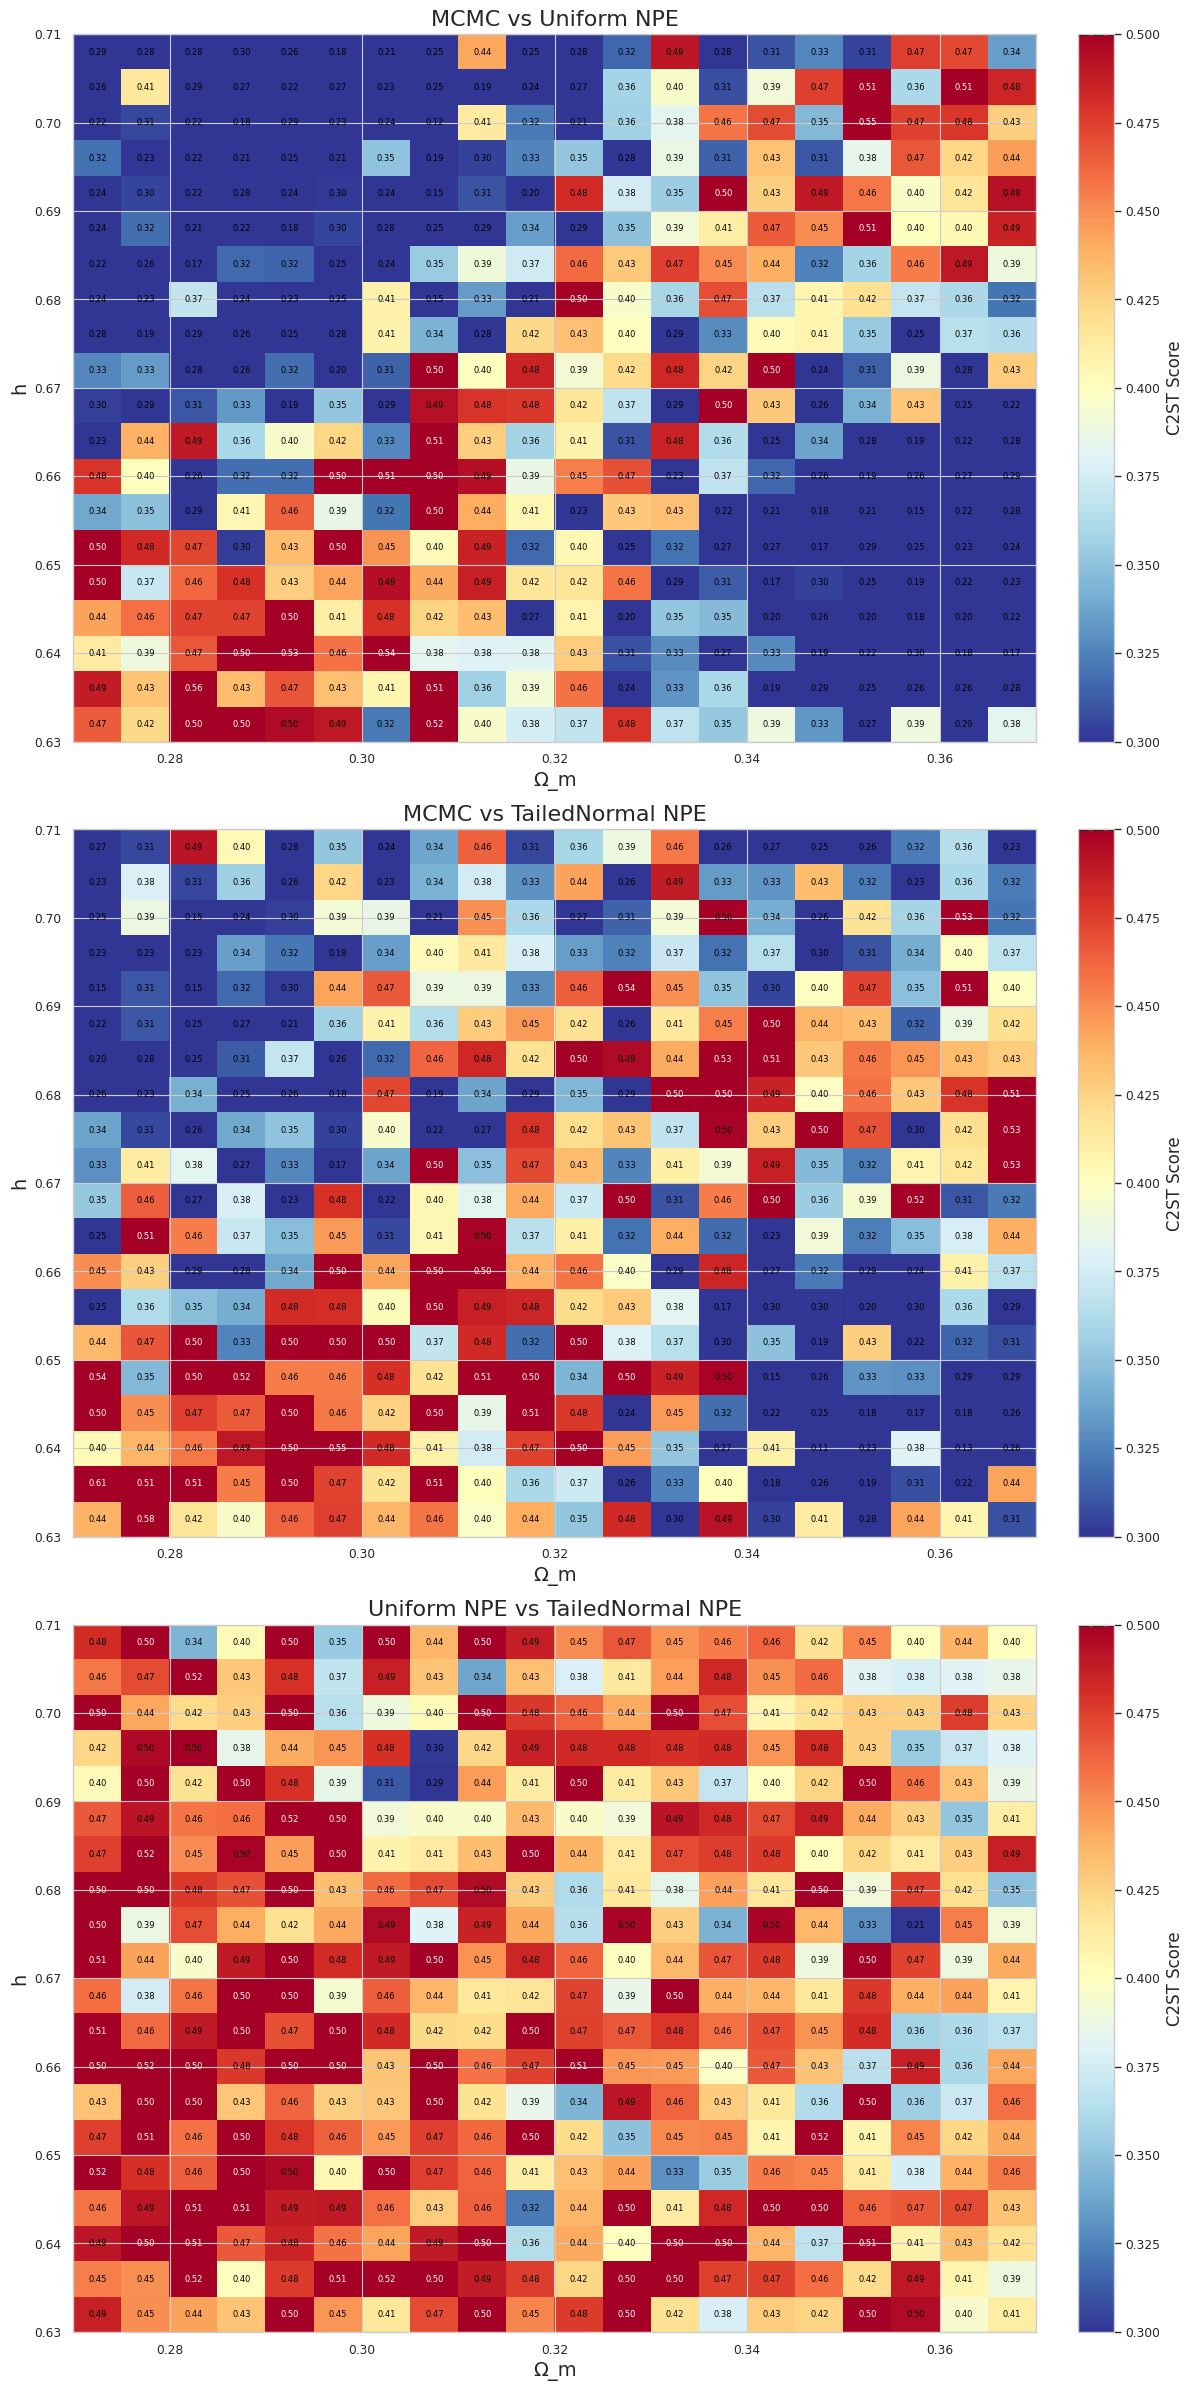

In [19]:
# Plot C2ST heatmaps for rectangular grid
save_path = 'sci-2-dim-figures/grid_c2st_heatmaps.png'

rect_evaluator.plot_c2st_heatmaps(
    c2st_grid_rect,
    n_points_per_dim,
    save_path=save_path
)
